In [1]:
import sys
sys.path.insert(1, '/home/yannik/vssil')

import matplotlib.pyplot as plt
import pylab
import torch
from torch.nn.functional import interpolate
from torchvision.io import read_video

from src.utils.kpt_utils import get_image_patches, kpts_2_img_coordinates
from contrastive_loss_test_data.test_data import load_sample_images
from contrastive_loss_test_data.test_keypoints import get_perfect_keypoints, get_bad_keypoints, get_random_keypoints

In [2]:
torch.manual_seed(123)

sample_size = 4
batch_size = 16

img_tensor = load_sample_images(sample_size=sample_size,
                                path="/home/yannik/vssil/contrastive_loss_test_data/990000.mp4").unsqueeze(0)
img_tensor = img_tensor.repeat((batch_size, 1, 1, 1, 1))

img_tensor = interpolate(img_tensor, size=(3, 64, 64))

N, T, C, H, W = img_tensor.shape

time_window = 5
patch_size = (5, 5)

pos_range = max(int(time_window / 2), 1) if time_window > 1 else 0
center_index = int(patch_size[0] / 2)

step_matrix = torch.ones(patch_size + (2,))

step_w = 2 / W
step_h = 2 / H

for k in range(0, patch_size[0]):
    for l in range(0, patch_size[1]):
        step_matrix[k, l, 0] = (l - center_index) * step_w
        step_matrix[k, l, 1] = (k - center_index) * step_h

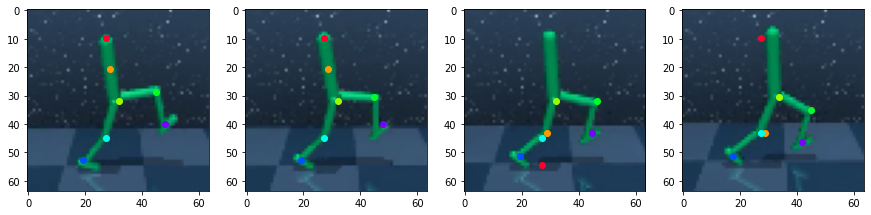

In [3]:
bad_kpt_coordinates = get_bad_keypoints(T=sample_size).unsqueeze(0)
bad_kpt_coordinates = bad_kpt_coordinates.repeat((batch_size, 1, 1, 1))
_, _, K, D = bad_kpt_coordinates.shape

cm = pylab.get_cmap('gist_rainbow')
bad_kpts = kpts_2_img_coordinates(bad_kpt_coordinates, tuple(img_tensor.shape[-2:]))
fig, ax = plt.subplots(1, sample_size, figsize=(15, 5))
for t in range(sample_size):
    ax[t].imshow(img_tensor[0, t].permute(1, 2, 0))
    for k in range(K):
        ax[t].scatter(bad_kpts[0, t, k, 0], bad_kpts[0, t, k, 1], color=cm(1.*k/K))
plt.show()

torch.Size([16, 4, 3, 64, 64])
torch.Size([16, 4, 7, 3])
torch.Size([16, 4, 7, 3, 5, 5])


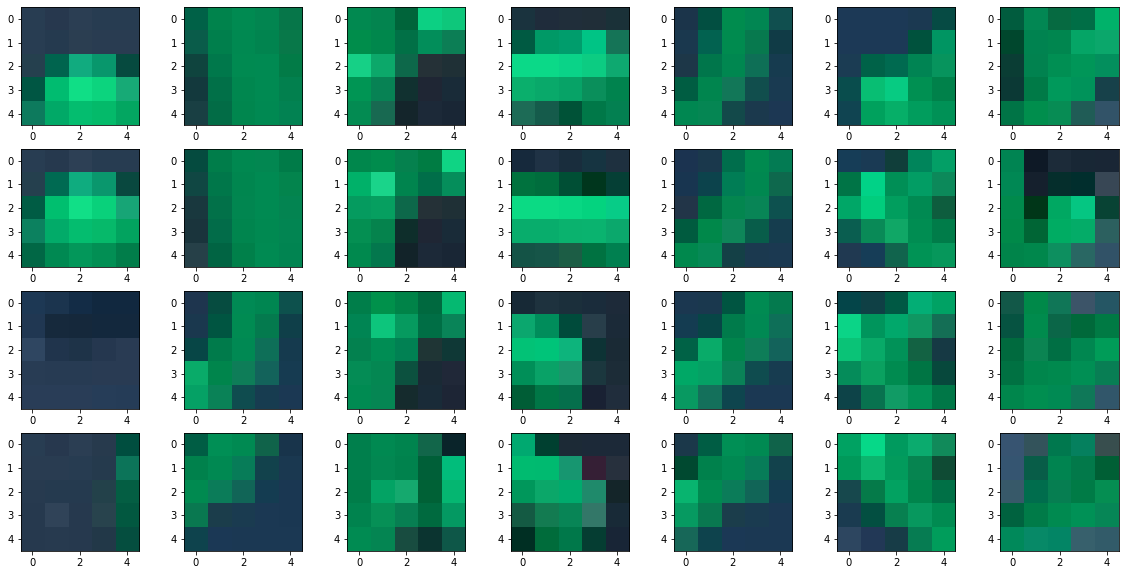

In [4]:
print(img_tensor.shape)  # (N, T, C, H, W)
print(bad_kpt_coordinates.shape)  # (N, T, K, D)

bad_kpt_patches = get_image_patches(image_sequence=img_tensor[0:1, ...],
                                        kpt_sequence=bad_kpt_coordinates[0:1, ...],
                                        patch_size=patch_size).repeat((N, 1, 1, 1, 1, 1))

print(bad_kpt_patches.shape)  # (N, T, K, C, H', W')
Hp, Wp = bad_kpt_patches.shape[-2:]

fig, ax = plt.subplots(T, K, figsize=(20, 10))
for t in range(T):
    for k in range(K):
        ax[t, k].imshow(bad_kpt_patches[0, t, k, ...].permute(1, 2, 0).cpu().numpy())